# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

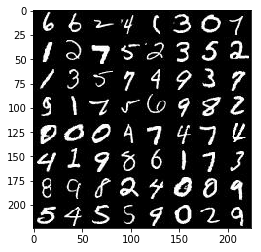

In [2]:
show_n_images = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

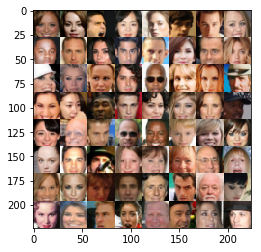

In [3]:
show_n_images = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, 
                                 (None, image_width, image_height, image_channels), 
                                 name='input_real')
    
    inputs_z = tf.placeholder(tf.float32,
                             (None, z_dim),
                             name='input_z')
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
#import numpy as np

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Following principles stated at https://arxiv.org/pdf/1511.06434.pdf p.3 and forum suggestions
    # one less layer to discriminator and leaky ReLU
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [19]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Following principles stated at https://arxiv.org/pdf/1511.06434.pdf p.3 and forum suggestions
    # one more layer to generator and ReLU
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.0, x1)
        # 4x4x512 now
        #print('x1:', x1.shape)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.0, x2)
        # 7x7x256 now
        #print('x2:', x2.shape)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.0, x3)
        # 14x14x128 now
        #print('x3:', x3.shape)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(0.0, x4)
        # 28x28x64 now
        #print('x4:', x4.shape)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28xout_channel_dim now
        #print('logits:', logits.shape)
        
        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    # model   
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    #losses
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                              labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                              labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize, control dependencies to ensure batch normalization works
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [23]:
import pickle
from time import gmtime, strftime

def show_save_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    pickle.dump(samples, open('samples/gan_samples_%s_%s.pkl'%(image_mode, strftime("%Y-%m-%dT%H.%M.%S", gmtime())), 'wb'))

In [24]:
def plot_generator_sample(pkl):
    image_mode = pkl.split('_')[2]
    samples = pickle.load(pkl, 'rb')
    cmap = None if image_mode == 'RGB' else 'gray'
    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """   
    samples, losses = [], []
    steps = 0
    print_every = 20
    show_every = 200
        
    #image_width, image_height, image_channels from data_shape
    input_real, input_z, learning_rate_placeholder = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_placeholder, beta1)
    #print('input real placeholder shape:', input_real.shape)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers - G twice as much the D - rescale images for G and D
                # print('batch images shape: ', batch_images.shape)
                batch_images = batch_images * 2
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z, 
                                                     learning_rate_placeholder: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, 
                                                     input_real: batch_images,
                                                     learning_rate_placeholder: learning_rate})

                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 64, input_z, data_shape[3], data_image_mode)
                    
    fig, ax = pyplot.subplots()
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8152... Generator Loss: 23.2527
Epoch 1/2... Discriminator Loss: 0.5743... Generator Loss: 10.7051
Epoch 1/2... Discriminator Loss: 3.2091... Generator Loss: 0.3929
Epoch 1/2... Discriminator Loss: 3.4715... Generator Loss: 0.1397
Epoch 1/2... Discriminator Loss: 1.0280... Generator Loss: 9.4538
Epoch 1/2... Discriminator Loss: 0.6744... Generator Loss: 2.5988
Epoch 1/2... Discriminator Loss: 0.7136... Generator Loss: 2.4805
Epoch 1/2... Discriminator Loss: 4.9145... Generator Loss: 10.9567
Epoch 1/2... Discriminator Loss: 0.9593... Generator Loss: 3.1911
Epoch 1/2... Discriminator Loss: 3.2806... Generator Loss: 5.3374


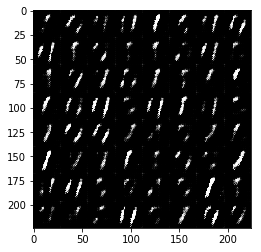

Epoch 1/2... Discriminator Loss: 2.0085... Generator Loss: 0.3723
Epoch 1/2... Discriminator Loss: 0.8943... Generator Loss: 3.2145
Epoch 1/2... Discriminator Loss: 1.0123... Generator Loss: 1.6470
Epoch 1/2... Discriminator Loss: 0.8972... Generator Loss: 1.3495
Epoch 1/2... Discriminator Loss: 1.1320... Generator Loss: 1.3368
Epoch 1/2... Discriminator Loss: 1.9551... Generator Loss: 0.4640
Epoch 1/2... Discriminator Loss: 1.3081... Generator Loss: 0.8532
Epoch 1/2... Discriminator Loss: 1.4020... Generator Loss: 6.2472
Epoch 1/2... Discriminator Loss: 1.5522... Generator Loss: 0.6266
Epoch 1/2... Discriminator Loss: 0.5491... Generator Loss: 2.9708


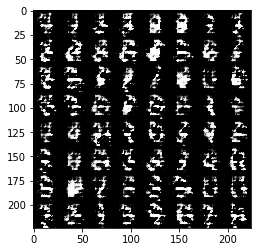

Epoch 1/2... Discriminator Loss: 1.0625... Generator Loss: 3.1331
Epoch 1/2... Discriminator Loss: 1.1215... Generator Loss: 1.6145
Epoch 1/2... Discriminator Loss: 1.3522... Generator Loss: 1.3399
Epoch 1/2... Discriminator Loss: 1.6926... Generator Loss: 0.7864
Epoch 1/2... Discriminator Loss: 2.1491... Generator Loss: 0.3086
Epoch 1/2... Discriminator Loss: 1.2066... Generator Loss: 3.2452
Epoch 1/2... Discriminator Loss: 1.1620... Generator Loss: 2.2041
Epoch 1/2... Discriminator Loss: 1.0883... Generator Loss: 1.2534
Epoch 1/2... Discriminator Loss: 2.6056... Generator Loss: 0.1868
Epoch 1/2... Discriminator Loss: 1.1230... Generator Loss: 0.9246


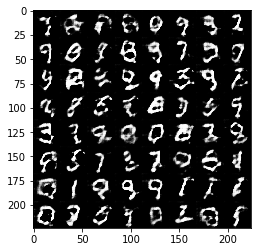

Epoch 1/2... Discriminator Loss: 1.5206... Generator Loss: 1.0382
Epoch 1/2... Discriminator Loss: 1.5531... Generator Loss: 0.4579
Epoch 1/2... Discriminator Loss: 1.7509... Generator Loss: 0.4602
Epoch 1/2... Discriminator Loss: 1.2201... Generator Loss: 0.8285
Epoch 1/2... Discriminator Loss: 0.8808... Generator Loss: 1.1480
Epoch 1/2... Discriminator Loss: 1.9947... Generator Loss: 0.4365
Epoch 1/2... Discriminator Loss: 1.8505... Generator Loss: 2.9729
Epoch 1/2... Discriminator Loss: 1.6206... Generator Loss: 0.5038
Epoch 1/2... Discriminator Loss: 1.1709... Generator Loss: 1.8095
Epoch 1/2... Discriminator Loss: 2.0608... Generator Loss: 0.3015


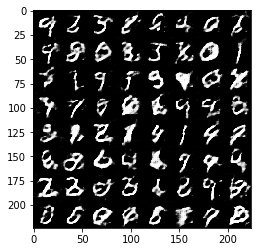

Epoch 1/2... Discriminator Loss: 1.3776... Generator Loss: 1.1124
Epoch 1/2... Discriminator Loss: 1.2438... Generator Loss: 1.0441
Epoch 1/2... Discriminator Loss: 1.4706... Generator Loss: 0.5388
Epoch 1/2... Discriminator Loss: 1.4454... Generator Loss: 2.4564
Epoch 1/2... Discriminator Loss: 1.2261... Generator Loss: 0.7561
Epoch 1/2... Discriminator Loss: 1.5758... Generator Loss: 0.4804
Epoch 1/2... Discriminator Loss: 1.7447... Generator Loss: 1.4854
Epoch 1/2... Discriminator Loss: 0.6230... Generator Loss: 1.9268
Epoch 1/2... Discriminator Loss: 1.8306... Generator Loss: 0.3383
Epoch 1/2... Discriminator Loss: 0.7138... Generator Loss: 1.6061


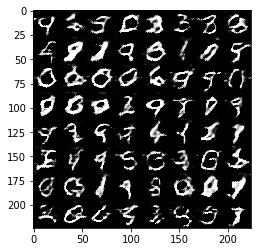

Epoch 1/2... Discriminator Loss: 0.8578... Generator Loss: 1.7046
Epoch 1/2... Discriminator Loss: 0.8837... Generator Loss: 1.3902
Epoch 1/2... Discriminator Loss: 1.3494... Generator Loss: 2.1430
Epoch 1/2... Discriminator Loss: 1.1451... Generator Loss: 1.1979
Epoch 1/2... Discriminator Loss: 1.2015... Generator Loss: 1.0651
Epoch 1/2... Discriminator Loss: 1.2834... Generator Loss: 0.7526
Epoch 1/2... Discriminator Loss: 1.3614... Generator Loss: 5.1815
Epoch 1/2... Discriminator Loss: 1.8477... Generator Loss: 3.8864
Epoch 1/2... Discriminator Loss: 1.3640... Generator Loss: 0.7790
Epoch 1/2... Discriminator Loss: 0.9789... Generator Loss: 1.8713


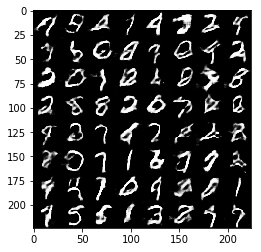

Epoch 1/2... Discriminator Loss: 0.9424... Generator Loss: 2.2589
Epoch 1/2... Discriminator Loss: 0.5670... Generator Loss: 2.2068
Epoch 1/2... Discriminator Loss: 1.4930... Generator Loss: 1.9071
Epoch 1/2... Discriminator Loss: 0.5865... Generator Loss: 2.9554
Epoch 1/2... Discriminator Loss: 0.9656... Generator Loss: 4.1463
Epoch 1/2... Discriminator Loss: 1.0551... Generator Loss: 0.8944
Epoch 1/2... Discriminator Loss: 1.7702... Generator Loss: 0.4505
Epoch 1/2... Discriminator Loss: 0.9237... Generator Loss: 1.2633
Epoch 1/2... Discriminator Loss: 0.8264... Generator Loss: 1.7404
Epoch 1/2... Discriminator Loss: 0.5288... Generator Loss: 2.9397


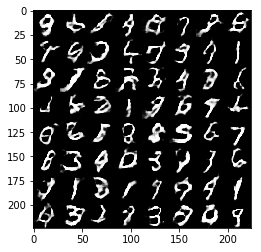

Epoch 1/2... Discriminator Loss: 0.6102... Generator Loss: 2.7950
Epoch 1/2... Discriminator Loss: 0.6571... Generator Loss: 4.3925
Epoch 1/2... Discriminator Loss: 1.1752... Generator Loss: 5.8134
Epoch 1/2... Discriminator Loss: 1.1481... Generator Loss: 0.7356
Epoch 1/2... Discriminator Loss: 0.7626... Generator Loss: 1.3634
Epoch 1/2... Discriminator Loss: 1.7543... Generator Loss: 0.5035
Epoch 1/2... Discriminator Loss: 1.8762... Generator Loss: 2.8883
Epoch 1/2... Discriminator Loss: 0.5287... Generator Loss: 4.1587
Epoch 1/2... Discriminator Loss: 0.9863... Generator Loss: 5.1008
Epoch 1/2... Discriminator Loss: 1.1438... Generator Loss: 1.4726


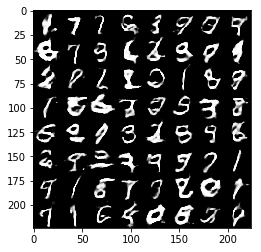

Epoch 1/2... Discriminator Loss: 0.6913... Generator Loss: 2.0654
Epoch 1/2... Discriminator Loss: 0.9900... Generator Loss: 1.0258
Epoch 1/2... Discriminator Loss: 0.4950... Generator Loss: 4.3186
Epoch 1/2... Discriminator Loss: 0.4491... Generator Loss: 3.9383
Epoch 1/2... Discriminator Loss: 0.9940... Generator Loss: 1.0730
Epoch 1/2... Discriminator Loss: 0.8494... Generator Loss: 1.3744
Epoch 1/2... Discriminator Loss: 2.0915... Generator Loss: 0.3387
Epoch 1/2... Discriminator Loss: 0.9246... Generator Loss: 3.7119
Epoch 1/2... Discriminator Loss: 0.5565... Generator Loss: 3.4612
Epoch 1/2... Discriminator Loss: 1.0988... Generator Loss: 0.9477


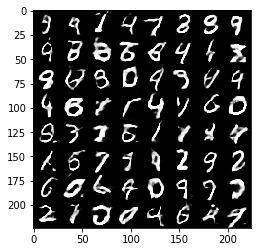

Epoch 1/2... Discriminator Loss: 1.0595... Generator Loss: 0.9705
Epoch 1/2... Discriminator Loss: 0.6131... Generator Loss: 2.5663
Epoch 1/2... Discriminator Loss: 0.4926... Generator Loss: 3.2432
Epoch 2/2... Discriminator Loss: 0.8213... Generator Loss: 1.7494
Epoch 2/2... Discriminator Loss: 0.5616... Generator Loss: 2.0849
Epoch 2/2... Discriminator Loss: 0.6195... Generator Loss: 2.6129
Epoch 2/2... Discriminator Loss: 0.9135... Generator Loss: 1.1725
Epoch 2/2... Discriminator Loss: 0.6774... Generator Loss: 2.8207
Epoch 2/2... Discriminator Loss: 0.9722... Generator Loss: 1.2794
Epoch 2/2... Discriminator Loss: 0.9801... Generator Loss: 0.9782


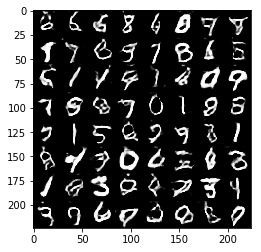

Epoch 2/2... Discriminator Loss: 0.5250... Generator Loss: 2.3460
Epoch 2/2... Discriminator Loss: 1.5070... Generator Loss: 0.5748
Epoch 2/2... Discriminator Loss: 0.3832... Generator Loss: 3.9831
Epoch 2/2... Discriminator Loss: 0.6311... Generator Loss: 1.8766
Epoch 2/2... Discriminator Loss: 1.5514... Generator Loss: 6.6506
Epoch 2/2... Discriminator Loss: 0.8169... Generator Loss: 1.8052
Epoch 2/2... Discriminator Loss: 0.9585... Generator Loss: 0.9541
Epoch 2/2... Discriminator Loss: 1.7571... Generator Loss: 3.1746
Epoch 2/2... Discriminator Loss: 1.2207... Generator Loss: 2.2284
Epoch 2/2... Discriminator Loss: 0.8136... Generator Loss: 1.7977


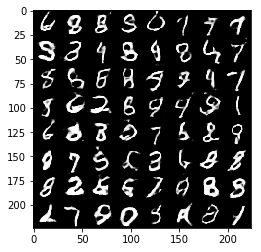

Epoch 2/2... Discriminator Loss: 0.7548... Generator Loss: 1.9790
Epoch 2/2... Discriminator Loss: 1.0717... Generator Loss: 1.0163
Epoch 2/2... Discriminator Loss: 0.5370... Generator Loss: 2.1256
Epoch 2/2... Discriminator Loss: 1.1765... Generator Loss: 0.9095
Epoch 2/2... Discriminator Loss: 1.0065... Generator Loss: 1.2169
Epoch 2/2... Discriminator Loss: 0.4424... Generator Loss: 3.3239
Epoch 2/2... Discriminator Loss: 1.3214... Generator Loss: 0.7239
Epoch 2/2... Discriminator Loss: 0.5903... Generator Loss: 1.9663
Epoch 2/2... Discriminator Loss: 0.4891... Generator Loss: 3.1428
Epoch 2/2... Discriminator Loss: 0.4122... Generator Loss: 3.1659


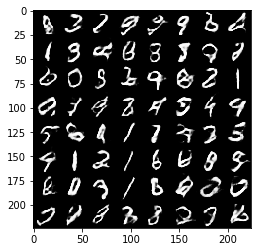

Epoch 2/2... Discriminator Loss: 0.7096... Generator Loss: 1.8119
Epoch 2/2... Discriminator Loss: 0.5954... Generator Loss: 2.0430
Epoch 2/2... Discriminator Loss: 0.7012... Generator Loss: 1.7308
Epoch 2/2... Discriminator Loss: 0.5294... Generator Loss: 2.4500
Epoch 2/2... Discriminator Loss: 0.6510... Generator Loss: 2.3866
Epoch 2/2... Discriminator Loss: 0.6151... Generator Loss: 6.3606
Epoch 2/2... Discriminator Loss: 0.8509... Generator Loss: 2.9417
Epoch 2/2... Discriminator Loss: 0.8872... Generator Loss: 1.9029
Epoch 2/2... Discriminator Loss: 0.5502... Generator Loss: 2.7084
Epoch 2/2... Discriminator Loss: 0.8501... Generator Loss: 4.4783


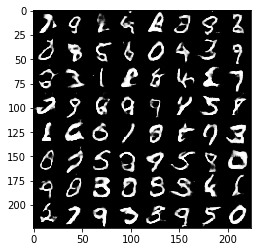

Epoch 2/2... Discriminator Loss: 0.7882... Generator Loss: 1.3973
Epoch 2/2... Discriminator Loss: 0.7399... Generator Loss: 2.4563
Epoch 2/2... Discriminator Loss: 1.4479... Generator Loss: 3.7947
Epoch 2/2... Discriminator Loss: 0.6792... Generator Loss: 1.6708
Epoch 2/2... Discriminator Loss: 0.5598... Generator Loss: 2.0898
Epoch 2/2... Discriminator Loss: 0.6045... Generator Loss: 3.8639
Epoch 2/2... Discriminator Loss: 0.5440... Generator Loss: 3.8122
Epoch 2/2... Discriminator Loss: 1.3116... Generator Loss: 0.7031
Epoch 2/2... Discriminator Loss: 0.5199... Generator Loss: 2.4862
Epoch 2/2... Discriminator Loss: 0.6126... Generator Loss: 1.9642


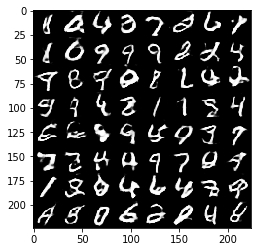

Epoch 2/2... Discriminator Loss: 0.6910... Generator Loss: 3.7664
Epoch 2/2... Discriminator Loss: 0.7049... Generator Loss: 1.7142
Epoch 2/2... Discriminator Loss: 0.4992... Generator Loss: 2.5324
Epoch 2/2... Discriminator Loss: 2.2179... Generator Loss: 0.3060
Epoch 2/2... Discriminator Loss: 0.6316... Generator Loss: 5.0494
Epoch 2/2... Discriminator Loss: 0.5927... Generator Loss: 2.0254
Epoch 2/2... Discriminator Loss: 0.9764... Generator Loss: 1.0651
Epoch 2/2... Discriminator Loss: 0.3928... Generator Loss: 3.7189
Epoch 2/2... Discriminator Loss: 0.4773... Generator Loss: 2.7739
Epoch 2/2... Discriminator Loss: 0.6345... Generator Loss: 1.7164


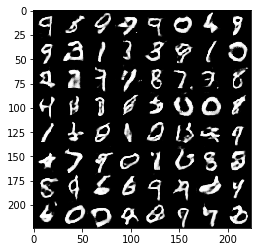

Epoch 2/2... Discriminator Loss: 1.1731... Generator Loss: 0.6804
Epoch 2/2... Discriminator Loss: 0.8318... Generator Loss: 1.2915
Epoch 2/2... Discriminator Loss: 0.4513... Generator Loss: 5.0447
Epoch 2/2... Discriminator Loss: 0.4402... Generator Loss: 4.3648
Epoch 2/2... Discriminator Loss: 0.4427... Generator Loss: 3.4603
Epoch 2/2... Discriminator Loss: 0.6586... Generator Loss: 2.3738
Epoch 2/2... Discriminator Loss: 0.8265... Generator Loss: 2.3147
Epoch 2/2... Discriminator Loss: 0.9335... Generator Loss: 1.2180
Epoch 2/2... Discriminator Loss: 0.6869... Generator Loss: 4.8897
Epoch 2/2... Discriminator Loss: 0.4902... Generator Loss: 3.5225


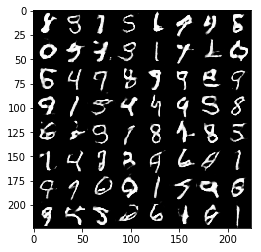

Epoch 2/2... Discriminator Loss: 0.9689... Generator Loss: 0.9305
Epoch 2/2... Discriminator Loss: 0.5268... Generator Loss: 2.6005
Epoch 2/2... Discriminator Loss: 0.7687... Generator Loss: 1.4461
Epoch 2/2... Discriminator Loss: 0.8902... Generator Loss: 1.4748
Epoch 2/2... Discriminator Loss: 0.6022... Generator Loss: 1.8899
Epoch 2/2... Discriminator Loss: 1.1745... Generator Loss: 0.7677
Epoch 2/2... Discriminator Loss: 0.5804... Generator Loss: 2.0252
Epoch 2/2... Discriminator Loss: 0.5069... Generator Loss: 3.0482
Epoch 2/2... Discriminator Loss: 0.6245... Generator Loss: 4.2323
Epoch 2/2... Discriminator Loss: 1.0562... Generator Loss: 1.0494


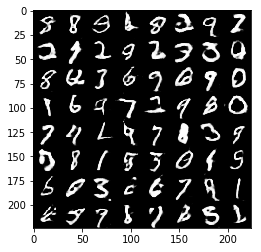

Epoch 2/2... Discriminator Loss: 0.7045... Generator Loss: 1.8900
Epoch 2/2... Discriminator Loss: 0.4688... Generator Loss: 3.6689
Epoch 2/2... Discriminator Loss: 0.8608... Generator Loss: 1.8517
Epoch 2/2... Discriminator Loss: 0.4269... Generator Loss: 3.0992
Epoch 2/2... Discriminator Loss: 0.4063... Generator Loss: 4.0747
Epoch 2/2... Discriminator Loss: 0.7624... Generator Loss: 2.3034
Epoch 2/2... Discriminator Loss: 0.9963... Generator Loss: 1.1164
Epoch 2/2... Discriminator Loss: 0.6949... Generator Loss: 1.9865
Epoch 2/2... Discriminator Loss: 1.5310... Generator Loss: 0.5816
Epoch 2/2... Discriminator Loss: 0.7159... Generator Loss: 1.5115


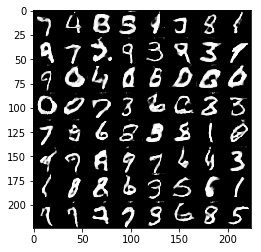

Epoch 2/2... Discriminator Loss: 1.0080... Generator Loss: 0.9089
Epoch 2/2... Discriminator Loss: 0.5961... Generator Loss: 3.6357
Epoch 2/2... Discriminator Loss: 0.5826... Generator Loss: 1.9540
Epoch 2/2... Discriminator Loss: 0.4811... Generator Loss: 2.6871
Epoch 2/2... Discriminator Loss: 0.4765... Generator Loss: 3.0226
Epoch 2/2... Discriminator Loss: 0.4853... Generator Loss: 2.5159
Epoch 2/2... Discriminator Loss: 1.2774... Generator Loss: 0.7611


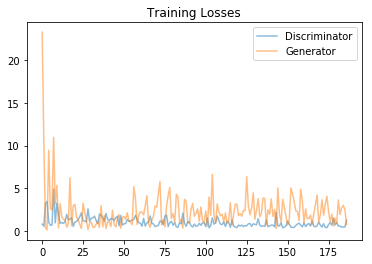

In [26]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
#print(mnist_dataset.shape)

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5320... Generator Loss: 4.7118
Epoch 1/1... Discriminator Loss: 0.5794... Generator Loss: 2.6713
Epoch 1/1... Discriminator Loss: 0.8363... Generator Loss: 12.3843
Epoch 1/1... Discriminator Loss: 0.7057... Generator Loss: 2.9175
Epoch 1/1... Discriminator Loss: 0.6557... Generator Loss: 3.9654
Epoch 1/1... Discriminator Loss: 0.6926... Generator Loss: 1.8487
Epoch 1/1... Discriminator Loss: 0.5320... Generator Loss: 2.4946
Epoch 1/1... Discriminator Loss: 0.5730... Generator Loss: 2.2828
Epoch 1/1... Discriminator Loss: 0.4634... Generator Loss: 3.7009
Epoch 1/1... Discriminator Loss: 0.3851... Generator Loss: 3.5305


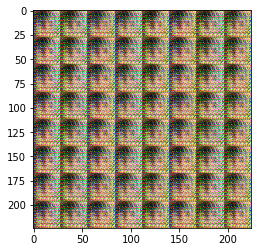

Epoch 1/1... Discriminator Loss: 0.4355... Generator Loss: 2.7927
Epoch 1/1... Discriminator Loss: 0.4356... Generator Loss: 3.3861
Epoch 1/1... Discriminator Loss: 0.4400... Generator Loss: 2.9570
Epoch 1/1... Discriminator Loss: 0.3913... Generator Loss: 3.5901
Epoch 1/1... Discriminator Loss: 0.4136... Generator Loss: 3.6841
Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 0.9908
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 1.0878
Epoch 1/1... Discriminator Loss: 0.7418... Generator Loss: 1.5302
Epoch 1/1... Discriminator Loss: 0.6842... Generator Loss: 2.9183
Epoch 1/1... Discriminator Loss: 0.7139... Generator Loss: 1.8335


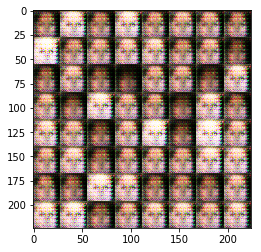

Epoch 1/1... Discriminator Loss: 0.5626... Generator Loss: 2.2063
Epoch 1/1... Discriminator Loss: 0.6250... Generator Loss: 3.3367
Epoch 1/1... Discriminator Loss: 0.6570... Generator Loss: 1.8008
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 0.5490... Generator Loss: 2.3732
Epoch 1/1... Discriminator Loss: 0.4447... Generator Loss: 3.0778
Epoch 1/1... Discriminator Loss: 0.5911... Generator Loss: 3.0477
Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 1.2805
Epoch 1/1... Discriminator Loss: 0.6592... Generator Loss: 1.9899
Epoch 1/1... Discriminator Loss: 0.8328... Generator Loss: 1.2576


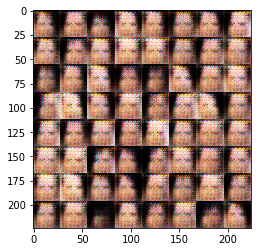

Epoch 1/1... Discriminator Loss: 0.6190... Generator Loss: 4.0458
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 1.1707
Epoch 1/1... Discriminator Loss: 0.5108... Generator Loss: 2.9430
Epoch 1/1... Discriminator Loss: 1.0087... Generator Loss: 1.7324
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 0.7550... Generator Loss: 1.8325
Epoch 1/1... Discriminator Loss: 0.6695... Generator Loss: 1.5909
Epoch 1/1... Discriminator Loss: 0.8087... Generator Loss: 1.6217
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 2.6615
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 1.1474


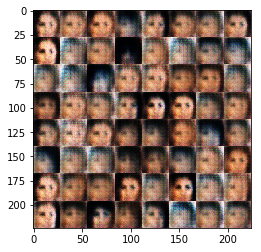

Epoch 1/1... Discriminator Loss: 0.6840... Generator Loss: 2.0689
Epoch 1/1... Discriminator Loss: 0.7444... Generator Loss: 2.3695
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 0.9086
Epoch 1/1... Discriminator Loss: 0.8311... Generator Loss: 2.6384
Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 1.3668
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 3.2156
Epoch 1/1... Discriminator Loss: 0.6886... Generator Loss: 1.8191
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 1.4642
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.6749


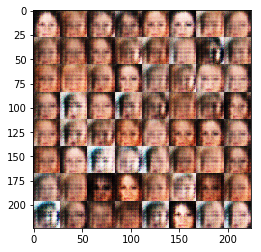

Epoch 1/1... Discriminator Loss: 0.9578... Generator Loss: 1.8932
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 0.9334
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 1.0037
Epoch 1/1... Discriminator Loss: 0.8141... Generator Loss: 1.6775
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 1.1925
Epoch 1/1... Discriminator Loss: 0.8720... Generator Loss: 1.5340
Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 1.1934
Epoch 1/1... Discriminator Loss: 0.8932... Generator Loss: 1.6073
Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 1.8016


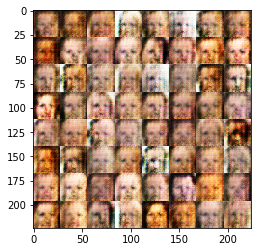

Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 1.1470
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 0.9504... Generator Loss: 1.4695
Epoch 1/1... Discriminator Loss: 1.8502... Generator Loss: 0.3840
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 2.2802
Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 2.0177
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 1.0774


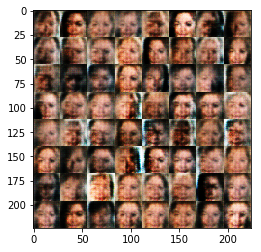

Epoch 1/1... Discriminator Loss: 1.5548... Generator Loss: 0.5392
Epoch 1/1... Discriminator Loss: 0.8922... Generator Loss: 1.6288
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 2.1137
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 0.9429
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 1.0146
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 1.5907
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 1.2539
Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 1.1768
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 1.4417
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 0.8347


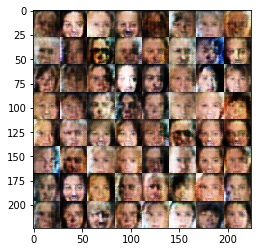

Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 1.7853
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 1.1418
Epoch 1/1... Discriminator Loss: 0.7584... Generator Loss: 1.5746
Epoch 1/1... Discriminator Loss: 0.7005... Generator Loss: 1.8497
Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.6004
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.7246


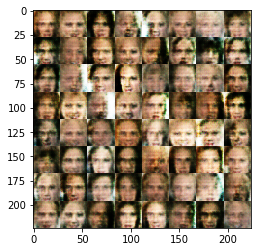

Epoch 1/1... Discriminator Loss: 0.7984... Generator Loss: 3.1598
Epoch 1/1... Discriminator Loss: 0.7302... Generator Loss: 1.7849
Epoch 1/1... Discriminator Loss: 0.7403... Generator Loss: 1.8206
Epoch 1/1... Discriminator Loss: 0.7504... Generator Loss: 2.2340
Epoch 1/1... Discriminator Loss: 1.5751... Generator Loss: 4.4208
Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 1.2728
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 0.4894... Generator Loss: 2.4845
Epoch 1/1... Discriminator Loss: 0.5920... Generator Loss: 2.6818
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.5430


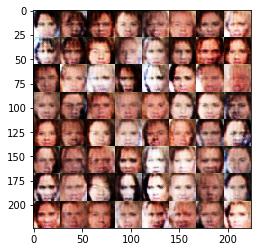

Epoch 1/1... Discriminator Loss: 0.7259... Generator Loss: 1.5111
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 1.2104
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.5681... Generator Loss: 0.4387
Epoch 1/1... Discriminator Loss: 0.9502... Generator Loss: 2.6571
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.5742
Epoch 1/1... Discriminator Loss: 0.7673... Generator Loss: 2.8278
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 0.9941
Epoch 1/1... Discriminator Loss: 0.6496... Generator Loss: 2.1310
Epoch 1/1... Discriminator Loss: 0.6547... Generator Loss: 2.1464


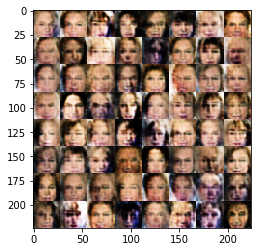

Epoch 1/1... Discriminator Loss: 0.6773... Generator Loss: 1.8156
Epoch 1/1... Discriminator Loss: 0.7498... Generator Loss: 2.1135
Epoch 1/1... Discriminator Loss: 0.6774... Generator Loss: 1.6173
Epoch 1/1... Discriminator Loss: 1.6709... Generator Loss: 0.3853
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 2.6834
Epoch 1/1... Discriminator Loss: 2.2437... Generator Loss: 0.1937
Epoch 1/1... Discriminator Loss: 0.6970... Generator Loss: 1.5205
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 1.0765
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.5585


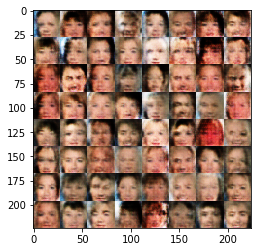

Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.4936
Epoch 1/1... Discriminator Loss: 0.7937... Generator Loss: 1.3603
Epoch 1/1... Discriminator Loss: 1.0062... Generator Loss: 2.1639
Epoch 1/1... Discriminator Loss: 1.7800... Generator Loss: 0.4001
Epoch 1/1... Discriminator Loss: 1.6020... Generator Loss: 0.4503
Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 1.6392
Epoch 1/1... Discriminator Loss: 0.7672... Generator Loss: 1.1835
Epoch 1/1... Discriminator Loss: 0.8904... Generator Loss: 1.2608
Epoch 1/1... Discriminator Loss: 0.8623... Generator Loss: 1.2995
Epoch 1/1... Discriminator Loss: 0.8247... Generator Loss: 1.4555


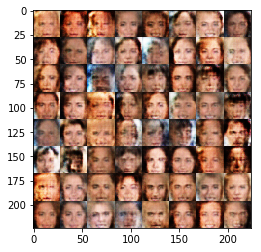

Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 1.0353
Epoch 1/1... Discriminator Loss: 0.9359... Generator Loss: 1.5954
Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 1.9778
Epoch 1/1... Discriminator Loss: 0.8956... Generator Loss: 1.3593
Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 1.6276
Epoch 1/1... Discriminator Loss: 1.9375... Generator Loss: 0.2825
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 2.7129
Epoch 1/1... Discriminator Loss: 0.9517... Generator Loss: 0.9893
Epoch 1/1... Discriminator Loss: 0.6682... Generator Loss: 2.8681
Epoch 1/1... Discriminator Loss: 0.6516... Generator Loss: 2.3120


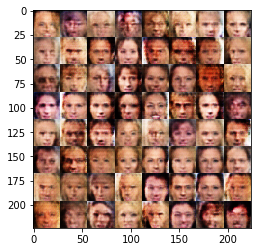

Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 3.8847
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 4.7466
Epoch 1/1... Discriminator Loss: 1.6359... Generator Loss: 0.4621
Epoch 1/1... Discriminator Loss: 0.7382... Generator Loss: 1.6841
Epoch 1/1... Discriminator Loss: 0.6002... Generator Loss: 2.3102
Epoch 1/1... Discriminator Loss: 0.7185... Generator Loss: 2.2673
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 2.9384
Epoch 1/1... Discriminator Loss: 0.7715... Generator Loss: 1.5140
Epoch 1/1... Discriminator Loss: 0.5050... Generator Loss: 2.1695


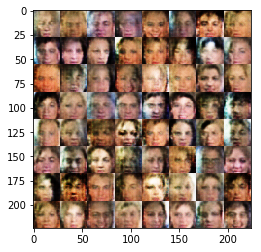

Epoch 1/1... Discriminator Loss: 0.6363... Generator Loss: 2.4957
Epoch 1/1... Discriminator Loss: 0.7808... Generator Loss: 1.7103
Epoch 1/1... Discriminator Loss: 0.8557... Generator Loss: 2.0416
Epoch 1/1... Discriminator Loss: 0.6197... Generator Loss: 1.8823
Epoch 1/1... Discriminator Loss: 0.6713... Generator Loss: 2.1411
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.4825
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.9765
Epoch 1/1... Discriminator Loss: 0.5275... Generator Loss: 2.4311
Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 2.0714
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.7754


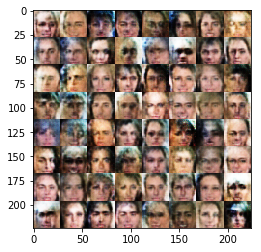

Epoch 1/1... Discriminator Loss: 1.5265... Generator Loss: 0.4770
Epoch 1/1... Discriminator Loss: 0.6224... Generator Loss: 2.1885
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.7013... Generator Loss: 0.3758
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.5252
Epoch 1/1... Discriminator Loss: 0.8001... Generator Loss: 1.5485
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 1.2134
Epoch 1/1... Discriminator Loss: 1.0976... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 0.7507... Generator Loss: 1.6462
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.6511


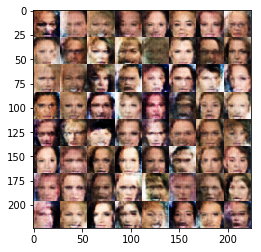

Epoch 1/1... Discriminator Loss: 0.8132... Generator Loss: 1.1996
Epoch 1/1... Discriminator Loss: 0.8452... Generator Loss: 1.2683
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 1.4393
Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 0.9795
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 1.0626
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.8540
Epoch 1/1... Discriminator Loss: 1.0325... Generator Loss: 1.3250
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.3868
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 1.1150
Epoch 1/1... Discriminator Loss: 0.7150... Generator Loss: 1.6548


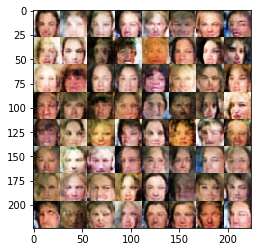

Epoch 1/1... Discriminator Loss: 0.6280... Generator Loss: 2.0353
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 2.4101
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 1.7048
Epoch 1/1... Discriminator Loss: 0.7591... Generator Loss: 1.3936
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 0.8397... Generator Loss: 1.2494
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 1.2676
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 1.8730
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 1.6689
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.8448


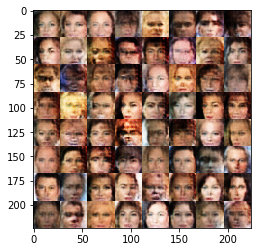

Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 1.3325
Epoch 1/1... Discriminator Loss: 0.9002... Generator Loss: 1.3023
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 0.7304... Generator Loss: 1.5676
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 1.1597
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 0.6862... Generator Loss: 1.7335


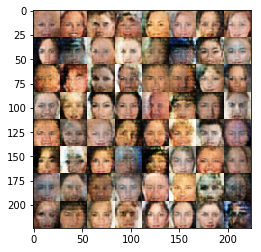

Epoch 1/1... Discriminator Loss: 0.7855... Generator Loss: 2.1724
Epoch 1/1... Discriminator Loss: 0.8151... Generator Loss: 1.2196
Epoch 1/1... Discriminator Loss: 1.0351... Generator Loss: 0.9583
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 0.9684
Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 1.4266
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 1.8101
Epoch 1/1... Discriminator Loss: 1.0733... Generator Loss: 2.8969
Epoch 1/1... Discriminator Loss: 0.6852... Generator Loss: 2.0611
Epoch 1/1... Discriminator Loss: 0.7361... Generator Loss: 1.9261
Epoch 1/1... Discriminator Loss: 0.9175... Generator Loss: 1.4124


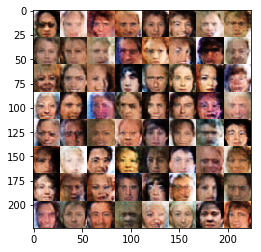

Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 0.8923... Generator Loss: 1.7431
Epoch 1/1... Discriminator Loss: 0.9013... Generator Loss: 1.6899
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 1.1296
Epoch 1/1... Discriminator Loss: 0.6170... Generator Loss: 2.7912
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 1.2286
Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 1.2265
Epoch 1/1... Discriminator Loss: 0.9620... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 0.9973... Generator Loss: 1.0673


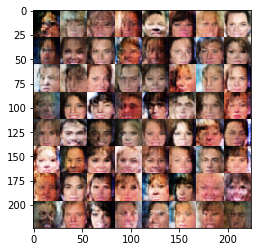

Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.5320
Epoch 1/1... Discriminator Loss: 0.8817... Generator Loss: 1.4864
Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 1.1585
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 0.8783... Generator Loss: 1.3626
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 3.3844
Epoch 1/1... Discriminator Loss: 1.5029... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 1.1333... Generator Loss: 1.0142
Epoch 1/1... Discriminator Loss: 0.8304... Generator Loss: 1.7353
Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 0.9706


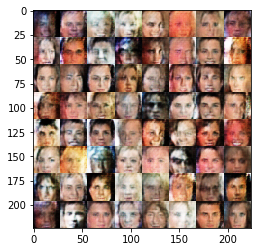

Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 1.2040
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 0.9444... Generator Loss: 1.3204
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 0.8342... Generator Loss: 1.9479
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 1.4891
Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 1.4653
Epoch 1/1... Discriminator Loss: 0.9580... Generator Loss: 2.1000
Epoch 1/1... Discriminator Loss: 0.5958... Generator Loss: 2.0893


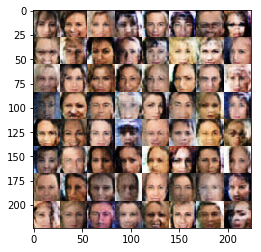

Epoch 1/1... Discriminator Loss: 0.8017... Generator Loss: 1.4568
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 1.0082
Epoch 1/1... Discriminator Loss: 0.9252... Generator Loss: 1.7687
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 1.0931
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 1.6753
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.9206
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 1.1011
Epoch 1/1... Discriminator Loss: 0.7373... Generator Loss: 1.6621
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 1.2349


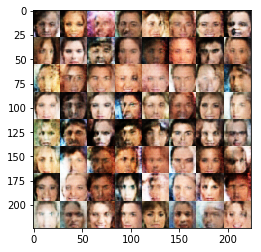

Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.0900... Generator Loss: 1.1185
Epoch 1/1... Discriminator Loss: 0.7308... Generator Loss: 1.6412
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.5043
Epoch 1/1... Discriminator Loss: 0.7649... Generator Loss: 2.0687
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 0.8692... Generator Loss: 1.3191
Epoch 1/1... Discriminator Loss: 1.0476... Generator Loss: 0.9550
Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 1.3481


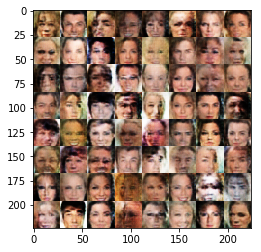

Epoch 1/1... Discriminator Loss: 0.7734... Generator Loss: 1.3275
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 0.9674
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 1.4292
Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 1.9016
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 2.0343
Epoch 1/1... Discriminator Loss: 0.8617... Generator Loss: 1.1775
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 1.6599
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 1.6231


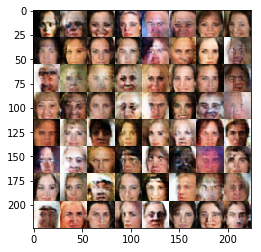

Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 1.3036
Epoch 1/1... Discriminator Loss: 0.9942... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 1.3545
Epoch 1/1... Discriminator Loss: 0.7665... Generator Loss: 1.5603
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.5291
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.5457


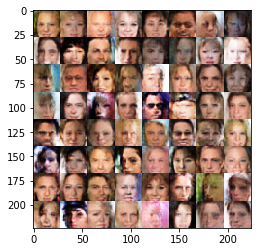

Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 1.1660
Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 0.9636
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 1.1284
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 0.7898... Generator Loss: 1.5116
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.5967


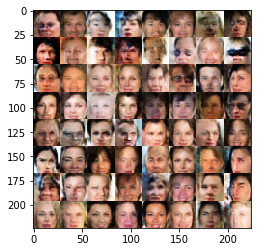

Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 1.0637
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.5051... Generator Loss: 0.4309
Epoch 1/1... Discriminator Loss: 0.9046... Generator Loss: 1.0653
Epoch 1/1... Discriminator Loss: 0.9007... Generator Loss: 1.8587
Epoch 1/1... Discriminator Loss: 1.6279... Generator Loss: 0.3735
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 1.0483
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.7578


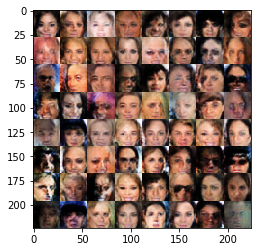

Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.5041
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 1.3466
Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 1.7537
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 1.3390
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 1.3839


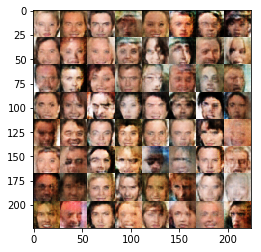

Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 1.1993
Epoch 1/1... Discriminator Loss: 0.9897... Generator Loss: 1.0049
Epoch 1/1... Discriminator Loss: 0.8227... Generator Loss: 1.6644
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 0.9103... Generator Loss: 1.4909


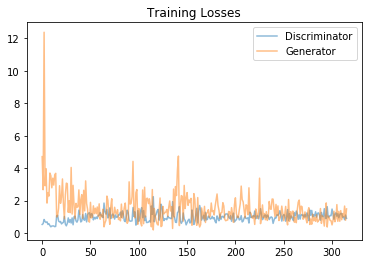

In [27]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.